In [1]:
from IPython.display import Image

https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function

- The reference GRPO implementation uses the **reverse KL** divergence, not the forward KL divergence.
- https://github.com/huggingface/trl/blob/main/trl/trainer/grpo_trainer.py
    - $L=\frac1n\sum\beta D_{KL}(q\|p)+A$
    - $q$ is the new trained model, and $p$ is the original reference model.
    - $p$ 待逼近的分布；
- grpo
    - $q(x) = \pi_{\theta}(o_{i,t}|q,o_{i,<t})$
    - $p(x) = \pi_{ref}(o_{i,t}|q,o_{i,<t})$

$$
\mathcal{J}_{GRPO}(\theta) = \mathbb{E}_{q \sim P(Q), \{o_i\}_{i=1}^G \sim \pi_{\theta_{old}}(O|q)} \left[ \frac{1}{G} \sum_{i=1}^G \frac{1}{|o_i|} \sum_{t=1}^{|o_i|} \min \left( \frac{\pi_\theta(o_{i,t}|q, o_{i,<t})}{\pi_{\theta_{old}}(o_{i,t}|q, o_{i,<t})} \hat{A}_{i,t}, \text{clip} \left( \frac{\pi_\theta(o_{i,t}|q, o_{i,<t})}{\pi_{\theta_{old}}(o_{i,t}|q, o_{i,<t})}, 1-\varepsilon, 1+\varepsilon \right) \hat{A}_{i,t} \right) - \beta D_{KL} (\pi_\theta || \pi_{ref}) \right] \tag{3}
$$

$$
\mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}] = \frac{\pi_{ref}(o_{i,t}|q, o_{i,<t})}{\pi_{\theta}(o_{i,t}|q, o_{i,<t})} - \log \frac{\pi_{ref}(o_{i,t}|q, o_{i,<t})}{\pi_{\theta}(o_{i,t}|q, o_{i,<t})} - 1
$$

## John Schulman's blog

http://joschu.net/blog/kl-approx.html

$$
r=\frac{p(x)}{q(x)}
$$

### $-\log r=\log \frac{q(x)}{p(x)}$

$$
kl(q\|p)=\sum_x q(x)\log \frac{q(x)}{p(x)}=\mathbb E_{x\sim q}\left[\log \frac{q(x)}{p(x)}\right]
$$
- it has high-variance, as it’s negative for half of the samples, whereas KL is always positive.
    - 采样点落在 $q(x)\lt p(x)$ 时，

In [19]:
import torch.distributions as dis
import torch
p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=1)
x = q.sample(sample_shape=(10_000_000,))

In [25]:
torch.sum((q.log_prob(x) - p.log_prob(x)) < 0)

tensor(4799598)

### $\frac12(\log r)^2$

### $r-1-\log r$

- $kl(q\|p)=r-1-\log r$ (without $q$)
- 保证非负 $\log x\leq x-1$

$$
\begin{split}
D_{KL}(q\|p)&=\sum q\log \frac{q}p\\
&=-\sum q\log\frac pq\\
&=1-\sum q\log\frac pq-1\\
&=\sum p-\sum q\log\frac pq-\sum q\\
&=\sum q\frac{p}q-\sum q\log\frac pq-\sum q\\
&=\sum q\left[\frac{p}{q}-\log\frac pq-1\right]
\end{split}
$$

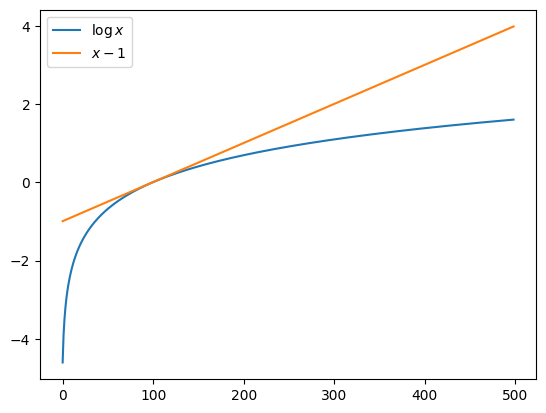

In [16]:
import matplotlib.pyplot as plt
import numpy as np
xs = np.arange(0.01, 5, 0.01)
plt.plot(np.log(xs), label=r'$\log x$')
plt.plot(xs-1, label='$x-1$')
plt.legend()

In [23]:
import torch.distributions as dis
p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=1)
x = q.sample(sample_shape=(10_000_000,))
truekl = dis.kl_divergence(q, p)
print("true", truekl)
logr = p.log_prob(x) - q.log_prob(x)
k1 = -logr
k2 = logr ** 2 / 2
k3 = (logr.exp() - 1) - logr
for k in (k1, k2, k3):
    print(k.mean(), (k.mean() - truekl) / truekl, k.std() / truekl)

true tensor(0.0050)
tensor(0.0050) tensor(0.0031) tensor(19.9963)
tensor(0.0050) tensor(0.0021) tensor(1.4167)
tensor(0.0050) tensor(-0.0004) tensor(1.4153)


### Reverse vs Forward KL

- Integrate along the given axis using the composite trapezoidal rule.
  
```python
def approx_kl(gmm_1, gmm_2, xs):
    ys = gmm_1.pdf(xs) * (gmm_1.logpdf(xs) - gmm_2.logpdf(xs))
    return np.trapz(ys, xs)
```

- https://www.tuananhle.co.uk/notes/reverse-forward-kl.html
    - 从 $p$（目标分布）出发，因为它是确定的，优化的目标是参数化的 $q_\phi$
    - Reverse KL: Zero-Forcing/Mode-Seeking
        - $q\log\frac qp$
            - forces $q_\phi$ to be zero where $p$ is zero
                - zero-forcing => mode seeking (不必然）
            - not always mode-seeking (subplot 2/3)
    - Forward KL: Mass-Covering/Mean-Seeking
        - $p\log\frac pq$
            - there is some mass under $q_\phi$ wherever there is some mass under $p$
            - $q$ zero avoiding：避免出现 0；
- 从下列的5个subplots中我们仅能得到的结论是
    - 原始的 p 分布是单峰，或者两峰足够接近时，也即是前三个子图，此时 $kl(q\|p)$ 与 $kl(p\|q)$ 是接近一致的；
    - 最后的两个子图，反向呈现出 mode seeking，前向呈现出 mean seeking；

In [5]:
# https://www.tuananhle.co.uk/notes/reverse-forward-kl/reverse_forward_kl.py
Image(url='./imgs/reverse_forward_kl.png', width=800)